In [ ]:
# Cell 1 — Install packages
!pip install -q scikit-learn xgboost imbalanced-learn shap matplotlib seaborn joblib

# reproducibility and warnings
import os, random, warnings
random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"
warnings.filterwarnings("ignore")
SEED = 42


In [ ]:
# Cell 2 — Upload dataset from your machine (use the UI that pops up)
from google.colab import files
uploaded = files.upload()  # select mine_detection_dataset.csv when prompted

# After uploading, verify filename
import pandas as pd, io
fn = list(uploaded.keys())[0]
print("Uploaded:", fn)

df = pd.read_csv(fn)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Saving mine_detection_dataset.csv to mine_detection_dataset.csv
Saving synthetic_mine_dataset.csv to synthetic_mine_dataset.csv
Uploaded: mine_detection_dataset.csv
Shape: (2000, 5)
Columns: ['Metal_Level', 'Magnetic_Field', 'Ground_Density', 'Thermal_Signature', 'Mine_Present']


,Metal_Level,Magnetic_Field,Ground_Density,Thermal_Signature,Mine_Present
0,0.724179,0.297447,0.227301,0.204902,0
1,0.565434,0.456644,0.393759,0.311195,0
2,0.761922,0.262274,0.403603,0.242747,0
3,0.980757,0.407612,0.494526,0.329441,1
4,0.541462,0.000000,0.126628,0.402887,0


,Metal_Level,Magnetic_Field,Ground_Density,Thermal_Signature,Mine_Present
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.605461,0.498213,0.392613,0.450335,0.551500
std,0.232247,0.276464,0.194667,0.221314,0.497465
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.444335,0.287262,0.262642,0.290427,0.000000
50%,0.611173,0.499984,0.393958,0.443285,1.000000
75%,0.770744,0.699663,0.525764,0.606282,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


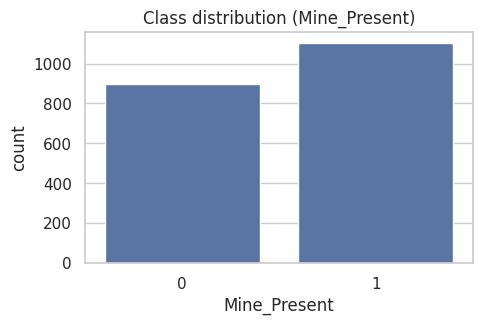

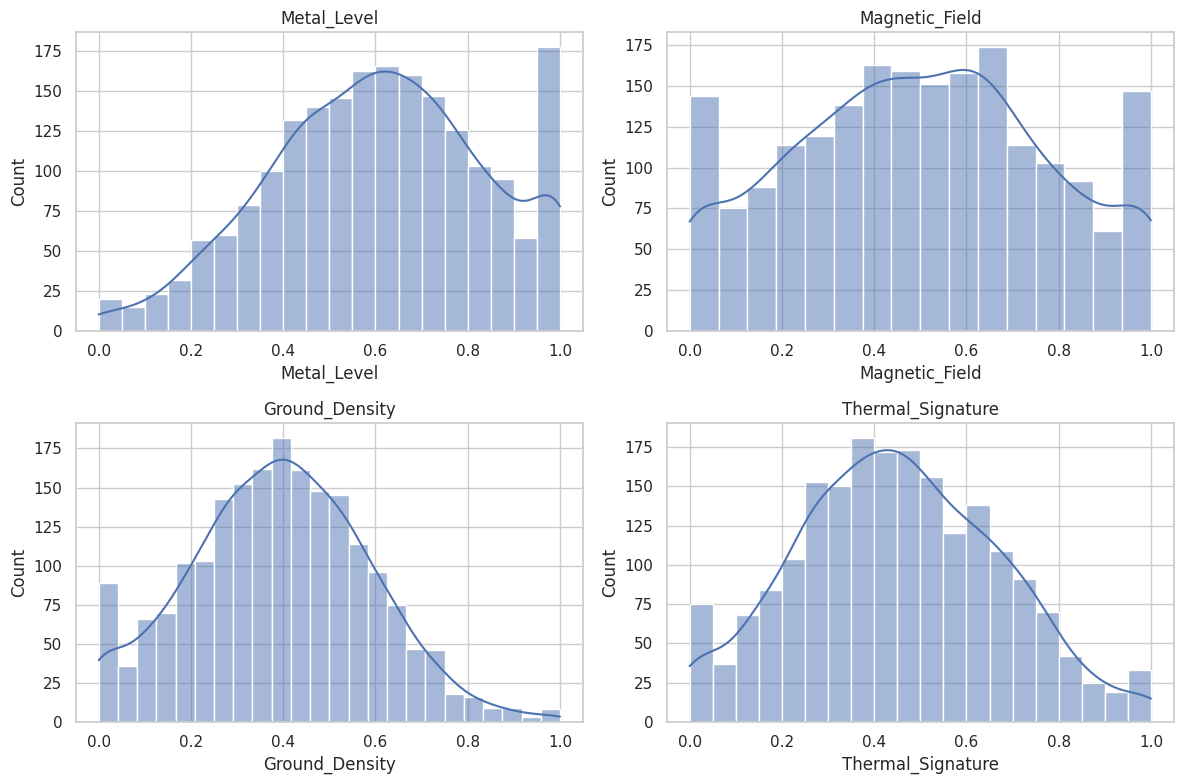

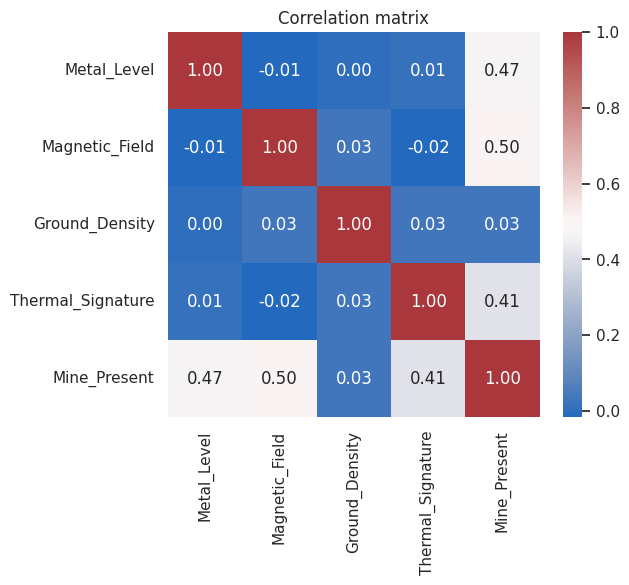

In [ ]:
# Cell 3 — EDA plots & stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

display(df.describe())

plt.figure(figsize=(5,3))
sns.countplot(x='Mine_Present', data=df)
plt.title("Class distribution (Mine_Present)")
plt.show()

# Feature histograms
features = ['Metal_Level','Magnetic_Field','Ground_Density','Thermal_Signature']
fig, axes = plt.subplots(2,2, figsize=(12,8))
for ax, col in zip(axes.flatten(), features):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

# Correlation
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix")
plt.show()


In [ ]:
# Cell 4 — Feature engineering (derived features)
import numpy as np

df['VH_ratio']   = df['Metal_Level'] / (df['Magnetic_Field'] + 1e-6)
df['V_minus_H']  = df['Metal_Level'] - df['Magnetic_Field']
df['intensity']  = np.sqrt(df['Metal_Level']**2 + df['Magnetic_Field']**2)
df['avg_signal'] = (df['Metal_Level'] + df['Magnetic_Field'])/2.0

# quick peek
display(df.head())


,Metal_Level,Magnetic_Field,Ground_Density,Thermal_Signature,Mine_Present,VH_ratio,V_minus_H,intensity,avg_signal
0,0.724179,0.297447,0.227301,0.204902,0,2.434643,0.426732,0.782885,0.510813
1,0.565434,0.456644,0.393759,0.311195,0,1.238234,0.108790,0.726801,0.511039
2,0.761922,0.262274,0.403603,0.242747,0,2.905050,0.499648,0.805800,0.512098
3,0.980757,0.407612,0.494526,0.329441,1,2.406102,0.573146,1.062089,0.694185
4,0.541462,0.000000,0.126628,0.402887,0,541461.656319,0.541462,0.541462,0.270731


In [ ]:
# Cell 5 — Split into train/test (stratified)
from sklearn.model_selection import train_test_split

FEATURES = ['Metal_Level','Magnetic_Field','Ground_Density','Thermal_Signature',
            'VH_ratio','V_minus_H','intensity','avg_signal']

X = df[FEATURES]
y = df['Mine_Present']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1600, 8) Test shape: (400, 8)


Baseline Accuracy: 0.9725
ROC AUC: 0.9976996385146237

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       179
           1       0.99      0.96      0.97       221

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



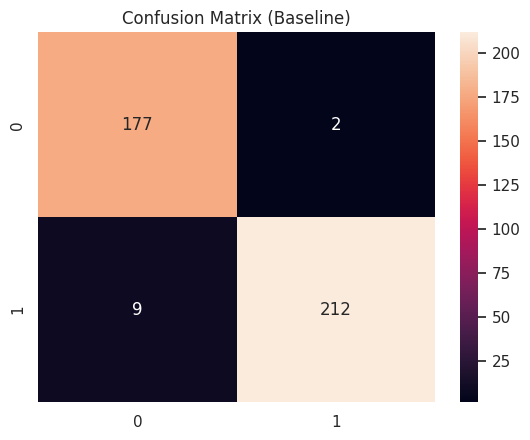

In [ ]:
# Cell 6 — Baseline pipeline training & evaluation
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=SEED)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d'); plt.title("Confusion Matrix (Baseline)"); plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
Tuned Accuracy: 0.97
Tuned ROC AUC: 0.9974215728405672

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       179
           1       0.99      0.95      0.97       221

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



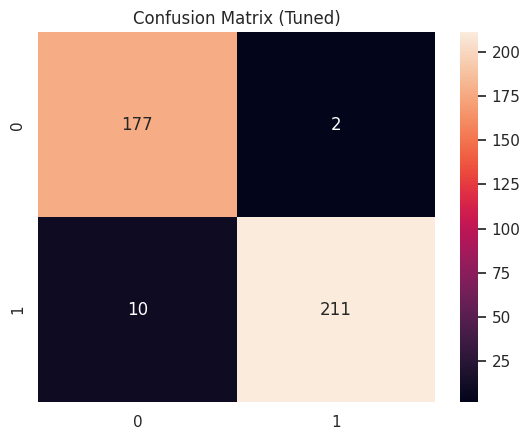

In [ ]:
# Cell 7 — Hyperparameter search (Randomized)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [None, 6, 12, 20],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4],
    'clf__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
rs = RandomizedSearchCV(pipe, param_distributions=param_dist,
                        n_iter=20, scoring='f1', cv=cv,
                        random_state=SEED, n_jobs=-1, verbose=2)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
best_model = rs.best_estimator_

# Evaluate the tuned model
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d'); plt.title("Confusion Matrix (Tuned)"); plt.show()


In [ ]:
# Cell 8 — XGBoost pipeline (optional comparison)
from xgboost import XGBClassifier
pipe_xgb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=SEED)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED, n_jobs=4))
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)
y_proba_xgb = pipe_xgb.predict_proba(X_test)[:,1]

print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGB ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))


XGB Accuracy: 0.98
XGB ROC AUC: 0.9991658029778306
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       179
           1       0.98      0.98      0.98       221

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



avg_signal 0.2638
Thermal_Signature 0.2613
intensity 0.1735
Magnetic_Field 0.1161
Metal_Level 0.0988
VH_ratio 0.0362
V_minus_H 0.0333
Ground_Density 0.0171
Generated SHAP values


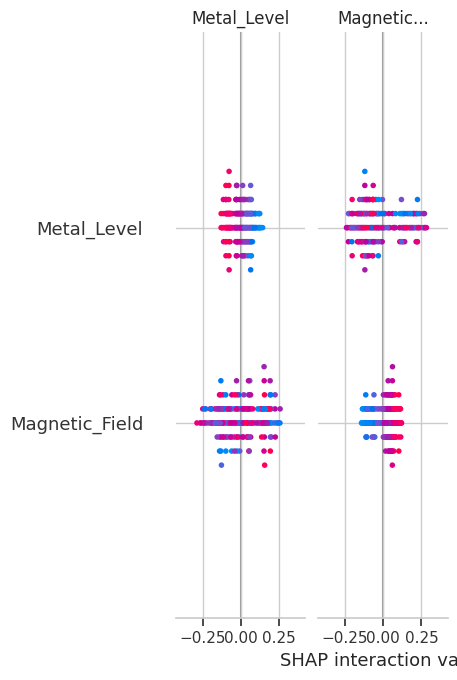

In [ ]:
# Cell 9 — Feature importance and SHAP (use best_model if available, else pipe)
model_for_shap = best_model.named_steps['clf'] if 'best_model' in globals() else pipe.named_steps['clf']
scaler_for_shap = best_model.named_steps['scaler'] if 'best_model' in globals() else pipe.named_steps['scaler']

# Feature importance (tree-based)
importances = model_for_shap.feature_importances_
for f,v in sorted(zip(FEATURES, importances), key=lambda x: -x[1])[:10]:
    print(f, round(v,4))

# SHAP (on a small subset for speed)
import shap, numpy as np
explainer = shap.TreeExplainer(model_for_shap)
X_sample = X_test.sample(n=min(200, len(X_test)), random_state=SEED)
X_sample_scaled = scaler_for_shap.transform(X_sample)  # scaler used before model
# shap expects original feature order; TreeExplainer works with model input space (we used scaled input)
# Create a DataFrame with the scaled features for SHAP (matching training preprocessing)
shap_values = explainer.shap_values(X_sample_scaled)
print("Generated SHAP values")

# Summary plot (visual)
shap.initjs()
shap.summary_plot(shap_values, X_sample, feature_names=FEATURES, show=True)


In [ ]:
# Cell 10 — Save final pipeline (choose the best model)
import joblib, json, os
out_dir = "/content/models"
os.makedirs(out_dir, exist_ok=True)

# Choose final pipeline to save:
final_pipe = best_model if 'best_model' in globals() else pipe  # best_model from search else baseline

joblib.dump(final_pipe, os.path.join(out_dir, "mine_detector_pipeline.pkl"))
joblib.dump(final_pipe.named_steps['scaler'], os.path.join(out_dir, "mine_detector_scaler.pkl"))
joblib.dump(final_pipe.named_steps['clf'], os.path.join(out_dir, "mine_detector_model_only.pkl"))

meta = {"features": FEATURES, "seed": SEED, "model_type": type(final_pipe.named_steps['clf']).__name__}
with open(os.path.join(out_dir, "metadata.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved files to", out_dir)
# Download links (Colab)
from google.colab import files
files.download(os.path.join(out_dir, "mine_detector_pipeline.pkl"))
files.download(os.path.join(out_dir, "metadata.json"))
files.download(os.path.join(out_dir, "mine_detector_scaler.pkl"))
files.download(os.path.join(out_dir, "mine_detector_model_only.pkl"))


Saved files to /content/models


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Quick inference test using the saved pipeline
import numpy as np, joblib, os

pipeline = joblib.load("/content/models/mine_detector_pipeline.pkl")

# Example sample (order must match FEATURES)
sample = [0.65, 0.22, 0.45, 0.33, 0.65/(0.22+1e-6), 0.65-0.22, (0.65**2+0.22**2)**0.5, (0.65+0.22)/2.0]
pred = pipeline.predict([sample])[0]
proba = pipeline.predict_proba([sample])[0,1]
print("Sample pred:", int(pred), "probability:", proba)

# ✅ Flask snippet (no .format issue)
print("\n--- Flask snippet (paste into routes.py) ---\n")

flask_snippet = f"""
from flask import Blueprint, request, jsonify
import joblib, numpy as np, os

bp = Blueprint("predict_bp", __name__)
BASE = os.path.dirname(os.path.abspath(__file__))
PIPE_PATH = os.path.join(BASE, "models", "mine_detector_pipeline.pkl")
pipeline = joblib.load(PIPE_PATH)

@bp.route("/api/predict/mine", methods=["POST"])
def predict_mine():
    body = request.get_json(force=True)
    arr = body.get("input")

    if not arr or len(arr) != {len(FEATURES)}:
        return jsonify({{"error": "Input must be a list of {len(FEATURES)} numeric features in order: {FEATURES}"}}), 400

    sample = np.array(arr).reshape(1, -1)
    pred = int(pipeline.predict(sample)[0])
    proba = float(pipeline.predict_proba(sample)[0,1])
    return jsonify({{"prediction": pred, "probability": proba}})
"""

print(flask_snippet)


Sample pred: 0 probability: 0.028333333333333335

--- Flask snippet (paste into routes.py) ---


from flask import Blueprint, request, jsonify
import joblib, numpy as np, os

bp = Blueprint("predict_bp", __name__)
BASE = os.path.dirname(os.path.abspath(__file__))
PIPE_PATH = os.path.join(BASE, "models", "mine_detector_pipeline.pkl")
pipeline = joblib.load(PIPE_PATH)

@bp.route("/api/predict/mine", methods=["POST"])
def predict_mine():
    body = request.get_json(force=True)
    arr = body.get("input")

    if not arr or len(arr) != 8:
        return jsonify({"error": "Input must be a list of 8 numeric features in order: ['Metal_Level', 'Magnetic_Field', 'Ground_Density', 'Thermal_Signature', 'VH_ratio', 'V_minus_H', 'intensity', 'avg_signal']"}), 400

    sample = np.array(arr).reshape(1, -1)
    pred = int(pipeline.predict(sample)[0])
    proba = float(pipeline.predict_proba(sample)[0,1])
    return jsonify({"prediction": pred, "probability": proba})



In [ ]:
# Cell 12 — Save basic evaluation report to disk
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
y_pred = final_pipe.predict(X_test)
y_proba = final_pipe.predict_proba(X_test)[:,1]
report = classification_report(y_test, y_pred, output_dict=True)
import json
with open("/content/models/eval_report.json", "w") as f:
    json.dump({
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "report": report
    }, f, indent=2)
from google.colab import files
files.download("/content/models/eval_report.json")
print("Saved evaluation report")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved evaluation report
